# Generating figures and analysis for assessing the quality of the cbmlib models

## Download Smiles structure representations from ChEMBL
... You could also simply use your browser

In [ ]:
# Retrieve: ftp://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_25/chembl_25_chemreps.txt.gz
from ftplib import FTP

ftp = FTP('ftp.ebi.ac.uk')     # connect to host, default port
ftp.login()
ftp.cwd('pub/databases/chembl/ChEMBLdb/releases/chembl_25')
with open('chembl_25_chemreps.txt.gz', 'wb') as fout:
    ftp.retrbinary('RETR chembl_25_chemreps.txt.gz', fout.write)

In [ ]:
# Decompress data
import gzip
with  gzip.open("chembl_25_chemreps.txt.gz","rt") as fin:
    with open("chembl_25_chemreps.txt","wt") as fout:
        for line in fin:
            fout.write(line)

## Wash the Smiles

In [ ]:
from ccbmlib.preprocessing import wash_molecules,export_washed
import rdkit.Chem as Chem
import os

mol_suppl = Chem.SmilesMolSupplier("chembl_25_chemreps.txt",delimiter="\t",smilesColumn=1,nameColumn=0)
if not os.path.exists("chembl25.smi"):
    washed = wash_molecules(mol_suppl)
    export_washed(washed, "chembl25.smi", "chembl25_duplicates.txt")


## Generate statistics

In [1]:
# Turn on logging as genrating staitstics can be very time consuming

import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.DEBUG)

In [2]:
import os
import ccbmlib.models as ccbm

# Make sure a data folder is specified!
data_folder = "/home/vogtm/data/ccbm_models/"
os.makedirs(data_folder, exist_ok=True)
ccbm.set_data_folder(data_folder)

RDKit WARNING: [19:03:16] Enabling RDKit 2019.09.3 jupyter extensions
DEBUG:ccbmlib.models:{frozenset({('pars', frozenset()), ('db', 'chembl25'), ('fp', 'atom_pairs')}): {'fp_file': 'chembl25-atom_pairs-18153657.fp.txt', 'pairwise-2048': 'chembl25-atom_pairs-18153657.stats-2048.pickle'}, frozenset({('pars', frozenset()), ('db', 'chembl25'), ('fp', 'avalon')}): {'fp_file': 'chembl25-avalon-18153657.fp.txt', 'pairwise-2048': 'chembl25-avalon-18153657.stats-2048.pickle'}, frozenset({('pars', frozenset()), ('fp', 'maccs'), ('db', 'chembl25')}): {'fp_file': 'chembl25-maccs-18153657.fp.txt', 'pairwise-2048': 'chembl25-maccs-18153657.stats-2048.pickle'}, frozenset({('db', 'chembl25'), ('fp', 'morgan'), ('pars', frozenset({('radius', 1)}))}): {'fp_file': 'chembl25-morgan-620758109.fp.txt', 'pairwise-2048': 'chembl25-morgan-620758109.stats-2048.pickle'}, frozenset({('pars', frozenset({('radius', 2)})), ('db', 'chembl25'), ('fp', 'morgan')}): {'fp_file': 'chembl25-morgan-620954718.fp.txt', 'pair

In [3]:
# Setup different fingerprints
fp_names = [ "atom_pairs", "avalon", "maccs", "morgan", "morgan", "torsions", 
        "hashed_atom_pairs","hashed_morgan","hashed_morgan","hashed_torsions", "rdkit"]
titles = ["Atom pairs","Avalon","MACCS","Morgan, radius 1","Morgan, radius 2","Topological torsions","Atom pairs, hashed",
         "Morgan, radius 1, hashed","Morgan, radius 2, hashed", "Topological torsions, hashed","RDKit" ]
pars = [{} for _ in range(11)]
pars[3] = pars[7] = {"radius":1}
pars[4] = pars[8] = {"radius":2}

#### Only a sample ...
Generating statistics for 1.7 mio compounds is time consuming. You might want to try the code on a small sample first.

In [4]:
def skip_some(seq_like,step):
    for i,x in enumerate(seq_like):
        if i%step==0:
            yield x

In [5]:
with open("chembl25.smi") as fin:
    with open("chembl25_sample.smi","w") as fout:
        for line in skip_some(fin,100):
            fout.write(line)

In [6]:
db_name = "chembl25_sample"
filename = "chembl25_sample.smi"

#uncomment to run on full data set
db_name = "chembl25"
filename = "chembl25.smi"


In [7]:
stats=[]
for fp_name,fp_par in zip(fp_names,pars):
    pwstats = ccbm.get_feature_statistics(db_name, fp_name, fp_par, filename)
    stats.append(pwstats)

INFO:ccbmlib.models:get_pairwise_stats: db:chembl25 fp_name:atom_pairs limit:2048
INFO:ccbmlib.models:get_pairwise_stats: unpickle stats from 'chembl25-atom_pairs-18153657.stats-2048.pickle'
INFO:ccbmlib.models:get_pairwise_stats: db:chembl25 fp_name:avalon limit:2048
INFO:ccbmlib.models:get_pairwise_stats: unpickle stats from 'chembl25-avalon-18153657.stats-2048.pickle'
INFO:ccbmlib.models:get_pairwise_stats: db:chembl25 fp_name:maccs limit:2048
INFO:ccbmlib.models:get_pairwise_stats: unpickle stats from 'chembl25-maccs-18153657.stats-2048.pickle'
INFO:ccbmlib.models:get_pairwise_stats: db:chembl25 fp_name:morgan limit:2048
INFO:ccbmlib.models:get_pairwise_stats: unpickle stats from 'chembl25-morgan-620758109.stats-2048.pickle'
INFO:ccbmlib.models:get_pairwise_stats: db:chembl25 fp_name:morgan limit:2048
INFO:ccbmlib.models:get_pairwise_stats: unpickle stats from 'chembl25-morgan-620954718.stats-2048.pickle'
INFO:ccbmlib.models:get_pairwise_stats: db:chembl25 fp_name:torsions limit:20

In [8]:
logger = logging.getLogger()
logger.setLevel(logging.WARN)

## Code for Model evaluation

For random sampling the code will tr to keep all fingerprints in memory.
This can be very taxing on low memory machines especially for fingerprints with a large number of features present per fingerpint
like atom pairs or the rdkit fingerprint. 

Modify the code below for reading fingerprints using skip_some to reduce the memory load. The code below illustrates how to do it
for the rdkit fingerprint.

In [9]:
# Fingerprint reader
def fingerprint_source(fname):
    with ccbm.auto_open(fname) as f:
        next(f)
        for line in f:
            if line.startswith("#"):
                continue
            entries = line.strip("\n").split("\t")
            fp = set(map(int,entries[1].split()))
            yield fp

            # Calculate Tanimoto coefficient
def tc(A,B):
    a=len(A)
    b=len(B)
    c=len(A.intersection(B))
    if c>0:
        return c/(a+b-c)
    else:
        return 0

In [10]:
import random
# Generate random Tc's
# if given one reference fingerprint stays fixed
def random_tcs(fps,n=100000,ref=None):
    tcs=[]
    if ref:
        for _ in range(n):
            a = random.choice(fps)
            tcs.append(tc(ref,a))
    else:
        for _ in range(n):
            a = random.choice(fps)
            b = random.choice(fps)
            tcs.append(tc(a,b))
    tcs.sort()
    return tcs

# Retrieve empirical CDF from sample of Tcs
# using 'num_data_pts' data points
def get_cdf_from_sample(tcs,num_data_pts=1000):
    tc_x = []
    hist_y = []
    n=len(tcs)
    ct = 0
    next_idx = 0
    for i,v in enumerate(tcs):
        if i>=next_idx:
            tc_x.append(v)
            hist_y.append(i/n)
            ct +=1
            next_idx = n*ct/num_data_pts
    tc_x.append(tcs[-1])
    hist_y.append(1)
    tc_x.append(1)
    hist_y.append(1)
    return tc_x, hist_y

# Retrieve modeled CDF at values given in 'tcs_x'
def get_cdf_from_model(tcs_x,cnd):
    return [cnd.cdf(x) for x in tcs_x]


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

dpi = 300


Atom pairs     KS_all: 0.054598330928484505 KS_90: 0.04253313301021333


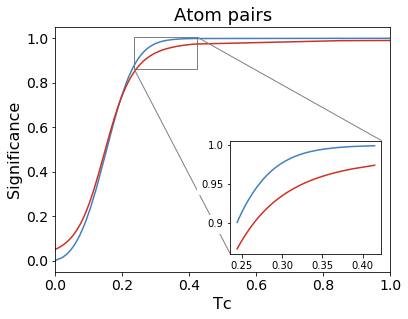

Avalon     KS_all: 0.06914481404608613 KS_90: 0.00991063320740293


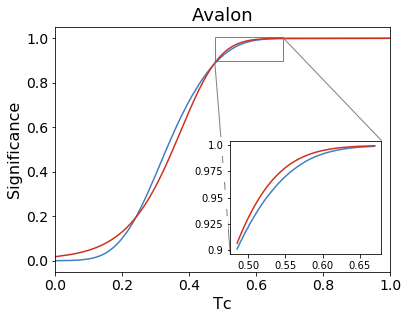

MACCS     KS_all: 0.02190816225244907 KS_90: 0.0043483216431597915


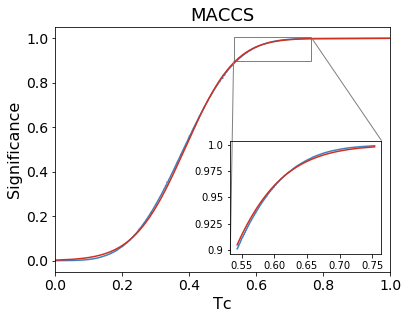

Morgan, radius 1     KS_all: 0.03639737285572775 KS_90: 0.005369660913889129


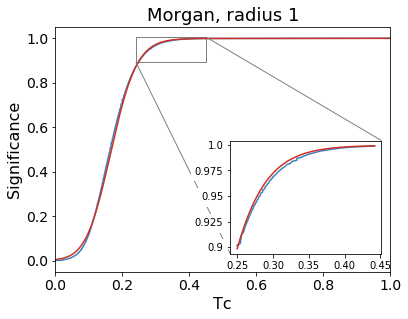

Morgan, radius 2     KS_all: 0.040559781217348156 KS_90: 0.0125653691483123


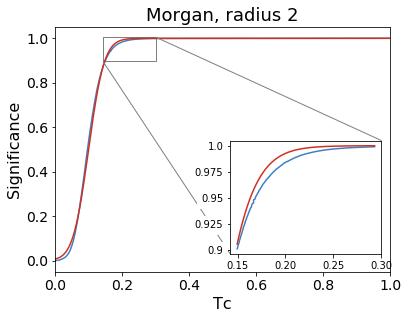

Topological torsions     KS_all: 0.09306170403353287 KS_90: 0.004676736138703896


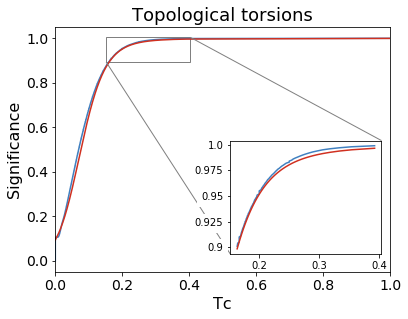

Atom pairs, hashed     KS_all: 0.08771596014874627 KS_90: 0.08771596014874627


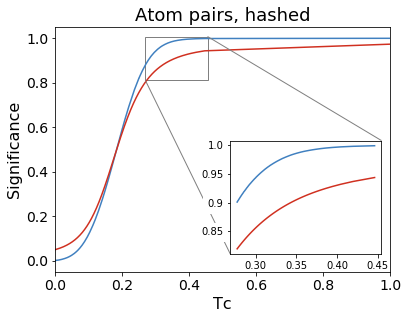

Morgan, radius 1, hashed     KS_all: 0.03369519416110267 KS_90: 0.0029552156508374505


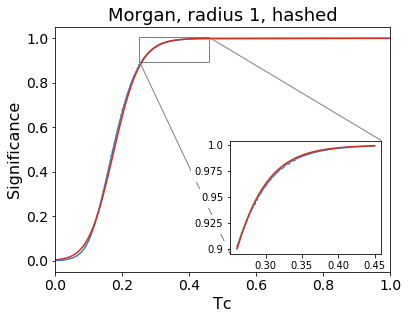

Morgan, radius 2, hashed     KS_all: 0.03903107941194661 KS_90: 0.008254591009078438


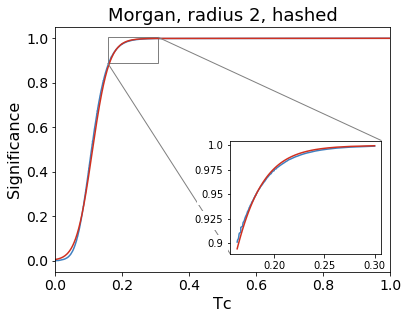

Topological torsions, hashed     KS_all: 0.06776068943112995 KS_90: 0.007532503599840701


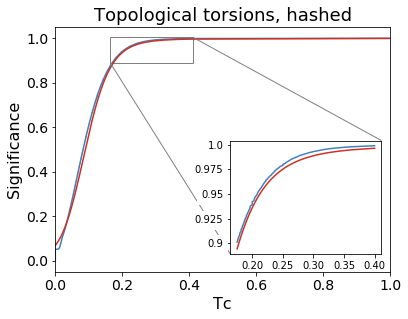

RDKit     KS_all: 0.08046654861898428 KS_90: 0.01699624402180855


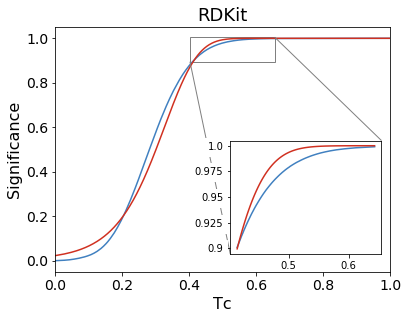

In [12]:
n=1000000

outf = open(db_name+"-KS-results.txt","w")
for fp_name,par,title in zip(fp_names[:],pars[:],titles):
    title0=fp_name
    if "radius" in par:
        title0+=str(par["radius"])
    img_filename=db_name+"-global_model-cdf-"+title0+".png"
    fp_file=ccbm.get_full_filename(ccbm.get_fingerprints(db_name,fp_name,par))
    fps=[]
    
    # Modify by demand using skip_some to reduce memory load
    fps =list(fingerprint_source(fp_file)) if fp_name!="rdkit" else list(skip_some(fingerprint_source(fp_file),3)) 

    pw = ccbm.get_feature_statistics(db_name,fp_name,par)
    tcs=random_tcs(fps,n)
    cnd=pw.get_tc_distribution()
    tc_x,hist_y = get_cdf_from_sample(tcs)
    cnd_y = get_cdf_from_model(tc_x,cnd)
    
    deltas=[abs(a-b) for a,b in zip(hist_y,cnd_y)]
    for i,v in enumerate(hist_y):
        if v>0.9:
            break
    KS_all=max(deltas)
    deltas=deltas[i:]
    KS_90=max(deltas)

    print(title,"    KS_all: {} KS_90: {}".format(KS_all,KS_90),file=outf)
    print(title,"    KS_all: {} KS_90: {}".format(KS_all,KS_90))

    fig, ax1 = plt.subplots(figsize=(8*0.75,6*0.75))

    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [0.53, 0.18, 0.35, 0.35]
    ax2 = fig.add_axes([left, bottom, width, height])
    mark_inset(ax1, ax2, loc1=1, loc2=3, fc="none", ec='0.5')
    axs=[ax1,ax2]
    plt.sca(axs[0])
    plt.plot(tc_x,hist_y,'#4080c0')
    plt.plot(tc_x,cnd_y,'#d03020')
    plt.gca().set_xlim(0,1)
    plt.sca(axs[1])
    
    plt.gca().patch.set_facecolor('w')
    plt.gca().patch.set_alpha(0)
    plt.plot(tc_x[i:-2],hist_y[i:-2],'#4080c0')
    plt.plot(tc_x[i:-2],cnd_y[i:-2],'#d03020')

    plt.sca(ax1)
    plt.title(title,fontsize=18)
    plt.xlabel("Tc",fontsize=16)
    plt.ylabel("Significance",fontsize=16)
    plt.gca().tick_params(axis="both",which="major",labelsize=14)

    yticks = ["{:.3}".format(x) for x in ax2.get_yticks()]
    ax2.set_yticklabels(yticks, backgroundcolor='w')
    plt.savefig(img_filename,dpi=dpi)
    plt.show()
    #break

outf.close()

## Generate figures for conditional distributions

In [13]:
import logging
import numpy as np

logger = logging.getLogger("FpDistModels")
logger.setLevel(logging.WARN)

n=100000

for fp_name,par,title in zip(fp_names,pars,titles):
    title0=fp_name
    if "radius" in par:
        title0+=str(par["radius"])
    img_filename=db_name+"-conditional_model-sig2sig-"+title0+".png"

    fp_file=ccbm.get_full_filename(ccbm.get_fingerprints(db_name,fp_name,par))
    fps=[]
    cnds=[]
    
    # Modify by demand using skip_some to reduce memory load
    fps = list(fingerprint_source(fp_file)) if fp_name!="rdkit" else list(skip_some(fingerprint_source(fp_file),3))

    pw = ccbm.get_feature_statistics(db_name,fp_name,par)
    cnds = []
    for _ in range(100):
        ref = random.choice(fps)
        tcs=random_tcs(fps,n,ref)
        cnd=pw.get_tc_distribution(ref)
        tc_x,hist_y = get_cdf_from_sample(tcs)
        cnd_y = get_cdf_from_model(tc_x,cnd)
        cnds.append(cnd_y)
    bp=[]
    for v in zip (*cnds):
        np.percentile(v,[0,5,25,50,75,95,100])
        bp.append(np.percentile(v,[0,5,25,50,75,95,100]))
    bp=list(zip(*bp))
    
    fig, ax1 = plt.subplots(figsize=(8*0.75,6*0.75))

    #These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [0.58, 0.18, 0.3, 0.3]
    ax2 = fig.add_axes([left, bottom, width, height])
    mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.5')
    axs=[ax1,ax2]
    plt.sca(axs[0])
    plt.title(title,fontsize=18)
    colors = ['#c0c0c0','#808080','#404040','#000000','#404040','#808080','#c0c0c0']
    #plt.fill_between(hist_y,bp[0],bp[-1],color='#e0e0e0')
    plt.fill_between(hist_y,bp[1],bp[-2],color='#c0c0c0')
    plt.fill_between(hist_y,bp[2],bp[-3],color='#808080')
    plt.plot(hist_y,hist_y,'#00d060')
    plt.plot(hist_y,bp[3],'#000000')
    
    plt.sca(axs[1])
    for i,v in enumerate(hist_y):
        if v>=0.9: break
    #plt.fill_between(hist_y,bp[0],bp[-1],color='#e0e0e0')
    plt.fill_between(hist_y[i:],bp[1][i:],bp[-2][i:],color='#c0c0c0')
    plt.fill_between(hist_y[i:],bp[2][i:],bp[-3][i:],color='#808080')
    plt.plot(hist_y[i:],hist_y[i:],'#00d060')
    plt.plot(hist_y[i:],bp[3][i:],'#000000')
    
    plt.sca(axs[0])
    plt.xlabel("Empirical significance",fontsize=16)
    plt.ylabel("Modeled significance",fontsize=16)
    plt.gca().tick_params(axis="both",which="major",labelsize=14)
    plt.savefig(img_filename,dpi=dpi)
    plt.show()
    

KeyboardInterrupt: 

## Some simple fingerprint statistics
- Average number of features per fingerprint
- standard deviation of the number of features

In [14]:
from math import sqrt
for fp_name,par,title in zip(fp_names[:],pars[:],titles):
    pw = ccbm.get_feature_statistics(db_name,fp_name,par)  
    print(title,"{:8.1f} {:8.1f}".format(pw.marginal.avg_no_of_features,sqrt(pw.marginal.no_of_features_variance)))

Atom pairs    199.8    155.9
Avalon    206.3     78.9
MACCS     52.1     13.5
Morgan, radius 1     30.5      8.4
Morgan, radius 2     51.0     15.3
Topological torsions     34.7     13.8
Atom pairs, hashed    186.3    126.4
Morgan, radius 1, hashed     30.1      8.2
Morgan, radius 2, hashed     50.3     14.9
Topological torsions, hashed     34.2     13.4
RDKit    877.5    324.0


## Relating Tanimoto coefficients of different fingerprints to each other

In [15]:
def inverse(f,s):
    tl = -5
    th = 5
    sl = f(tl)
    sh = f(th)
    if s <= sl:
        return tl
    if s >= sh:
        return th
    while th - tl > 1e-6:
        tm = (th+tl)/2
        sm = f(tm)
        if sm < s:
            tl = tm
            sl = sm
        elif sm > s:
            th = tm
            sh = sm
        else:
            return tm
    alpha = (s-sl)/(sh-sl)
    return (1-alpha)*tl + alpha*th


0.674372147259001


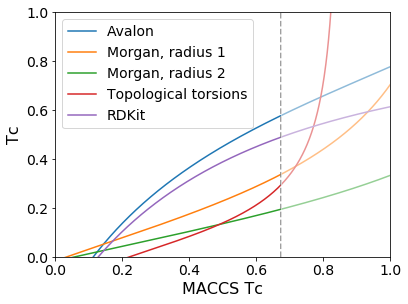

In [16]:
import numpy as np

img_filename=db_name+"-maccs_tc_to_tc.png"
fig, ax1 = plt.subplots(figsize=(8*0.75,6*0.75))
plt.sca(ax1)
ref=2
sel = [1,2,3,4,5,10]
sel.remove(ref)
fps = [list(zip(fp_names,pars,stats))[i] for i in sel]
modelx = stats[ref].get_tc_distribution()
for i in sel:
    x = np.linspace(0,1,1001)
    modely = stats[i].get_tc_distribution()
    pvalues = [modelx.cdf(t) for t in x]
    y = [inverse(modely.cdf,p) for p in pvalues]
    #x,y = zip(*[(x,y) for x,y,p in zip(x,y,pvalues) if p>=0.01 and p<=0.999])
    plt.plot(x,y,label=titles[i])
plt.legend(fontsize=14)
plt.xlabel("MACCS Tc",fontsize=16)
plt.ylabel("Tc",fontsize=16)
plt.gca().tick_params(axis="both",which="major",labelsize=14)
xupp=modelx.icdf(0.99)
print(xupp)
r=plt.Rectangle((xupp,0),1-xupp,1,fill=True,color="w",zorder=2.5,alpha=0.5)
plt.gca().add_patch(r)
plt.plot([xupp,xupp],[0,1],"--",color="#808080")
plt.gca().set_xlim(0,1)
plt.gca().set_ylim(0,1)
plt.savefig(img_filename,dpi=dpi)

#### Corresponding Tc values

In [17]:
print("Corresponding Tc")
sig=stats[ref].get_cached_tc_distribution().cdf(0.6)
for i in sel+[ref]:
    print(titles[i],"Tc: %.2f"%inverse(stats[i].get_tc_distribution().cdf,sig))

Avalon 0.53
Morgan, radius 1 0.29
Morgan, radius 2 0.17
Topological torsions 0.21
RDKit 0.45
MACCS 0.60
